In [30]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import matplotlib
from statsmodels.stats.outliers_influence import variance_inflation_factor

#데이터 특성을 보기 위해 시각화
data=pd.read_csv('C:\\Users\\leeso\\anaconda3\\envs\\myenv\\sol\\correlation_input_data.csv', header=1)
data=data[1:]
data=data.apply(pd.to_numeric)
print(data.info())
sns.pairplot(data=data)

# drop na and inf
mo_data=data.replace([np.inf,-np.inf], np.nan).dropna()

#단순회귀분석에서 유의한 변수
variables = list(data.columns)[:-6]
pvalues=[]

for variable in variables:
    lm_formula='patent_utility_change ~ '+variable
    lm_model = smf.ols(formula=lm_formula, data=mo_data).fit()
    print(lm_model.summary())
    if lm_model.pvalues[1]<0.05:
        pvalues.append('p-value<0.05')
    else:
        pvalues.append('p-value=>0.05')

print(pd.DataFrame(pvalues,index=variables))

#variable 간의 상관행렬을 Heatmap로 작성
sns.heatmap(mo_data.corr(), annot = True, cmap='BuPu',fmt='.1f')
plt.show()

########################################################################################################################
#전진 선택법을 이용한 다중 회귀 분석
y = mo_data['patent_utility_change']  ## 반응 변수
selected_variables = []  ## 선택된 변수들
sl_enter = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)  ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = mo_data[selected_variables + [col]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pval[col] = model.pvalues[col]
    min_pval = pval.min()
    if min_pval < sl_enter:  ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(mo_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_forward = selected_variables

########################################################################################################################
#후진소거법을 이용한 다중 회귀 분석
y = mo_data['patent_utility_change']  ## 반응 변수
selected_variables = variables  ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    X = sm.add_constant(mo_data[selected_variables])
    p_vals = sm.OLS(y, X).fit().pvalues[1:]  ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max()  ## 최대 p-value
    if max_pval >= sl_remove:  ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(mo_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_backward = selected_variables

########################################################################################################################
#단계별선택법을 이용한 다중회귀분석
y = mo_data['patent_utility_change']  ## 반응 변수
selected_variables = []  ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)  ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = mo_data[selected_variables + [col]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pval[col] = model.pvalues[col]
    min_pval = pval.min()
    if min_pval < sl_enter:  ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = mo_data[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y, selected_X).fit().pvalues[1:]  ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove:  ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(mo_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_stepwise= selected_variables


print(selected_variables_using_stepwise)
print(selected_variables_using_forward)
print(selected_variables_using_backward)


lm_model_forward = smf.ols('patent_utility_change~ export_percent',data=mo_data).fit()
print(lm_model_forward.summary())
lm_model_backward = smf.ols('patent_utility_change~ export_change+import_percent+import_change',data=mo_data).fit()
print(lm_model_backward.summary())
lm_model_stepwise = smf.ols('patent_utility_change~ import_percent',data=mo_data).fit()
print(lm_model_stepwise.summary())




ValueError: Unable to parse string "2019-11-23" at position 0

In [31]:
# 내코드
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import matplotlib
from statsmodels.stats.outliers_influence import variance_inflation_factor

#데이터 특성을 보기 위해 시각화
data=pd.read_csv('C:\\Users\\leeso\\anaconda3\\envs\\myenv\\sol\\correlation_input_data.csv')
data=data[1:]
data = data.drop(data.columns[0], axis=1)
data

,date,ftof_meeting,n_ftof_meeting,prevention,regulation,covid,covid_num
1,2019-11-22,-509.0,-125.0,-797.0,0,-37.0,0
2,2019-11-23,-633.0,242.0,-657.0,-14,-82.0,0
3,2019-11-24,-101.0,69.0,-798.0,0,-93.0,0
4,2019-11-25,-338.0,-1.0,-668.0,0,-56.0,0
5,2019-11-26,-493.0,-207.0,-609.0,0,-127.0,0
...,...,...,...,...,...,...,...
373,2020-11-28,-333.0,-127.0,-644.0,-1833,-1071.0,488
374,2020-11-29,-293.0,-175.0,-755.0,-1617,-584.0,449
375,2020-11-30,-167.0,-306.0,-1012.0,-1764,-605.0,377
376,2020-12-01,-171.0,-391.0,-792.0,-1380,-685.0,451


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 1 to 377
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            377 non-null    object 
 1   ftof_meeting    377 non-null    float64
 2   n_ftof_meeting  377 non-null    float64
 3   prevention      377 non-null    float64
 4   regulation      377 non-null    int64  
 5   covid           377 non-null    float64
 6   covid_num       377 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 20.7+ KB
None


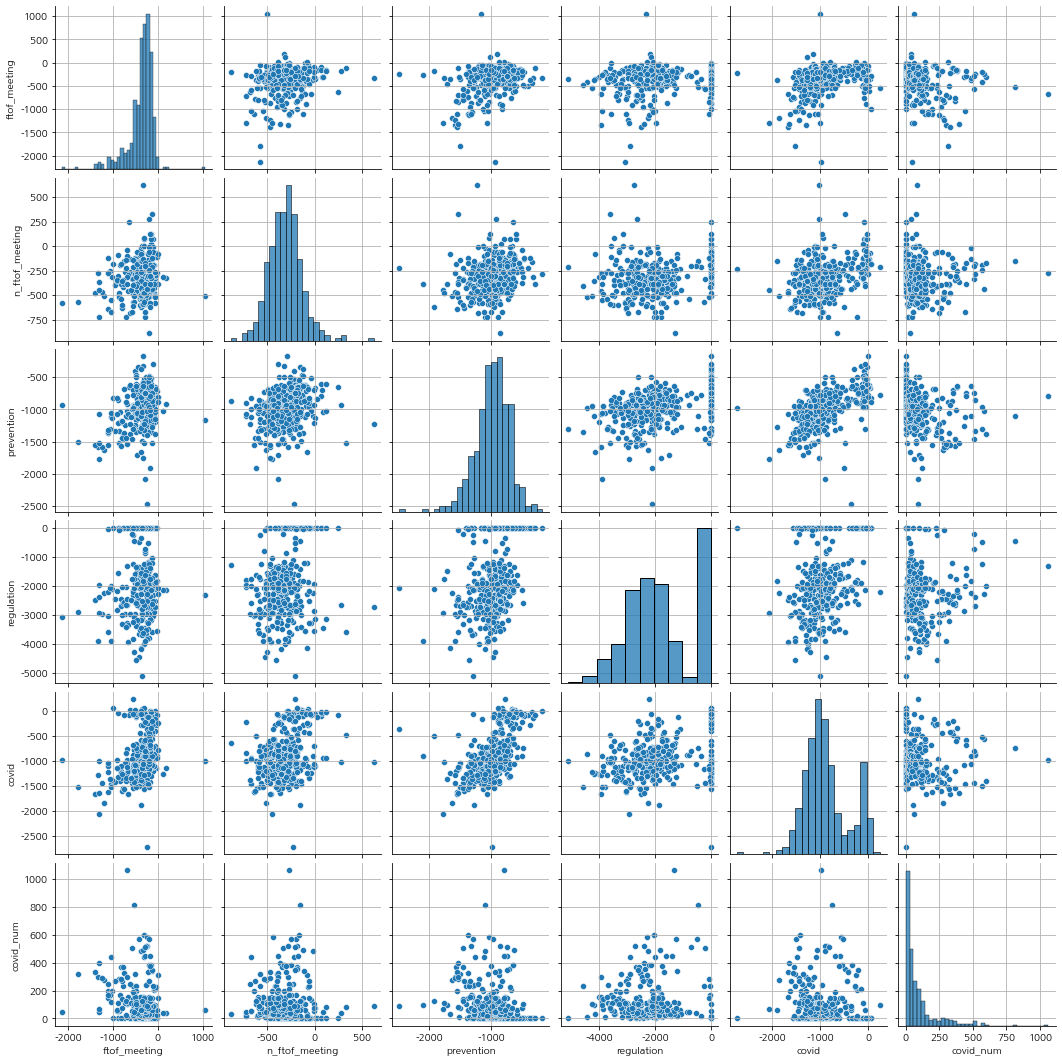

In [32]:
#data=data.apply(pd.to_numeric)
print(data.info())
sns.pairplot(data=data)

In [33]:
# drop na and inf
mo_data=data.replace([np.inf,-np.inf], np.nan).dropna()
mo_data

,date,ftof_meeting,n_ftof_meeting,prevention,regulation,covid,covid_num
1,2019-11-22,-509.0,-125.0,-797.0,0,-37.0,0
2,2019-11-23,-633.0,242.0,-657.0,-14,-82.0,0
3,2019-11-24,-101.0,69.0,-798.0,0,-93.0,0
4,2019-11-25,-338.0,-1.0,-668.0,0,-56.0,0
5,2019-11-26,-493.0,-207.0,-609.0,0,-127.0,0
...,...,...,...,...,...,...,...
373,2020-11-28,-333.0,-127.0,-644.0,-1833,-1071.0,488
374,2020-11-29,-293.0,-175.0,-755.0,-1617,-584.0,449
375,2020-11-30,-167.0,-306.0,-1012.0,-1764,-605.0,377
376,2020-12-01,-171.0,-391.0,-792.0,-1380,-685.0,451


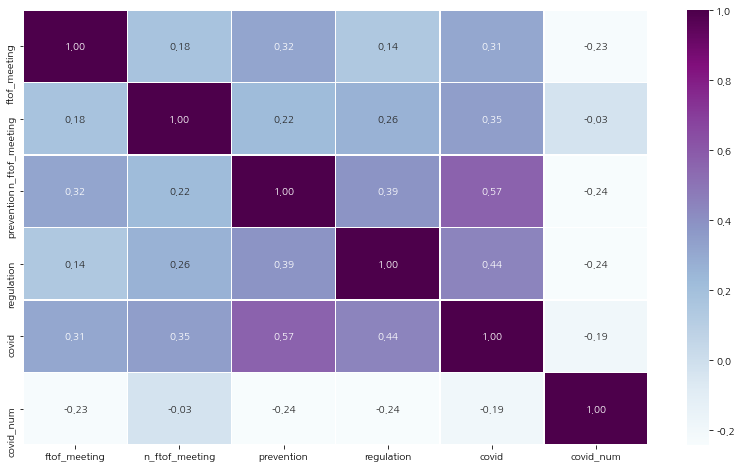

In [36]:
variables = list(data.columns)
#variable 간의 상관행렬을 Heatmap로 작성
sns.heatmap(mo_data.corr(), annot = True, cmap='BuPu',fmt='.2f', linewidths=.5)
plt.show()

In [52]:
import scipy.stats

scipy.stats.pearsonr(mo_data['ftof_meeting'], mo_data['covid_num'])

(-0.23421096416162893, 4.29559901204629e-06)

In [56]:
scipy.stats.pearsonr(mo_data['n_ftof_meeting'], mo_data['covid_num'])

(-0.03209631499519674, 0.5344099263542007)

In [53]:
scipy.stats.pearsonr(mo_data['prevention'], mo_data['covid_num'])

(-0.24335033138230455, 1.7409157927938073e-06)

In [54]:
scipy.stats.pearsonr(mo_data['regulation'], mo_data['covid_num'])

(-0.24170075745170072, 2.054637448077559e-06)

In [55]:
scipy.stats.pearsonr(mo_data['covid'], mo_data['covid_num'])

(-0.19365396973816956, 0.00015465727733229943)

In [37]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 
mpl.rcParams['axes.unicode_minus'] = False

In [59]:
# regulation과 prevention과 covid_num 파일 따로 만들기
from os import listdir
from os.path import isfile, join
import json
from pandas import Series, DataFrame
import pandas as pd

new_df = pd.DataFrame()
new_df['date'] = mo_data['date']

new_df['ftof_meeting'] = mo_data['ftof_meeting']
new_df['ftof_meeting_rate'] = ''

new_df['prevention'] = mo_data['prevention']
new_df['prevention_rate'] = ''

new_df['regulation'] = mo_data['regulation']
new_df['regulation_rate'] = ''

new_df['covid_num'] = mo_data['covid_num']

new_df

,date,ftof_meeting,ftof_meeting_rate,prevention,prevention_rate,regulation,regulation_rate,covid_num
1,2019-11-22,-509.0,,-797.0,,0,,0
2,2019-11-23,-633.0,,-657.0,,-14,,0
3,2019-11-24,-101.0,,-798.0,,0,,0
4,2019-11-25,-338.0,,-668.0,,0,,0
5,2019-11-26,-493.0,,-609.0,,0,,0
...,...,...,...,...,...,...,...,...
373,2020-11-28,-333.0,,-644.0,,-1833,,488
374,2020-11-29,-293.0,,-755.0,,-1617,,449
375,2020-11-30,-167.0,,-1012.0,,-1764,,377
376,2020-12-01,-171.0,,-792.0,,-1380,,451


In [58]:
new_df.to_csv('correlation_result_data.csv', encoding='utf-8-sig')